# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [32]:
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

# Organizing columns
measure_cols = ['avgWeight_per_day', 'calories', 'heart', 'steps']
survey_cols = ['diet', 'medication', 'symptoms']
result_col = 'symptoms'

# Shift surveuy columns
for col in survey_cols:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)

survey_cols = ['diet', 'medication']

RF Cleaning

In [33]:
def mark_day_for_removal(df, cols, max_nans, window):
    df = df.copy()
    df['remove'] = False

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()

        for col in cols:
            n = len(group)
            for start in range(n):
                end = min(start + window, n)
                window_slice = group.iloc[start:end]

                # Count NaNs in this window for this column
                nan_count = window_slice[col].isna().sum()

                if nan_count >= max_nans:
                    # Mark rows with NaN in this column for removal
                    for idx in window_slice.index:
                        if pd.isna(group.at[idx, col]):
                            df.at[idx, 'remove'] = True

    return df

fitbit_data = mark_day_for_removal(fitbit_data, measure_cols+survey_cols, 3, 7)

In [34]:
def impute_forward_fill(df, cols):
    df = df.copy()
    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        for col in cols:
            group[col] = group[col].ffill()  # forward fill
        df.loc[group.index, cols] = group[cols]
    return df

fb_data = impute_forward_fill(fitbit_data, measure_cols+survey_cols)

In [35]:
scaler = MinMaxScaler().fit(fb_data[measure_cols])
fb_data[measure_cols] = scaler.transform(fb_data[measure_cols])

In [36]:
def final_clean(df, cols):
    df = df.copy()

    # Remove rows marked True in the 'remove' column
    df = df[df['remove'] != True]

    # Remove rows that have any NaN in the specified columns
    df = df.dropna(subset=cols)

    return df

fb_data = final_clean(fb_data, measure_cols+survey_cols+['symptoms'])

In [ ]:
fb_data

In [21]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=fb_data)

https://docs.google.com/spreadsheets/d/138nudnomgQwZuT6tTmQw1HKdYAq--trGncIyWnpYo08/edit#gid=0


In [ ]:
fb_data['symptoms'].value_counts()

# Random Forest

In [52]:
# Step 1: Get unique user IDs
unique_users = fb_data['fitbit_user_id'].unique()

# Step 2: Split user IDs into train/test
train, test = train_test_split(
    unique_users, test_size=0.2, random_state=42
)

# Step 3: Filter original DataFrame based on user ID
train = fb_data[fb_data['fitbit_user_id'].isin(train)].reset_index(drop=True)
test = fb_data[fb_data['fitbit_user_id'].isin(test)].reset_index(drop=True)

x_train = train[measure_cols+survey_cols]
y_train = train[result_col]
x_test = test[measure_cols+survey_cols]
y_test = test[result_col]

In [53]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [55]:
# Predict class and probabilities
y_pred = rf.predict(x_test)
y_prob = rf.predict_proba(x_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.671602326811211
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.87      0.80      2558
         1.0       0.39      0.32      0.35      1019
         2.0       0.00      0.00      0.00       205

    accuracy                           0.67      3782
   macro avg       0.38      0.40      0.39      3782
weighted avg       0.61      0.67      0.64      3782

AUC Score: 0.6665682413385864
Confusion Matrix:
 [[2213  343    2]
 [ 692  327    0]
 [  45  160    0]]


CV

In [56]:
x = fb_data[measure_cols+survey_cols+['fitbit_user_id']]
targets = fb_data[result_col]

sgkf = StratifiedGroupKFold(n_splits=5)

groups = x['fitbit_user_id']  # or however you track user grouping

In [57]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [41]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="accuracy")

array([0.64348543, 0.60131076, 0.57358491, 0.62821214, 0.61603722])

In [42]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="f1_macro")

array([0.35732243, 0.27456861, 0.3005927 , 0.38209308, 0.33573947])

In [43]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="f1_weighted")

array([0.60723733, 0.530946  , 0.53694295, 0.62961411, 0.5842747 ])

In [44]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="roc_auc_ovr_weighted")

array([0.67258715, 0.4139447 , 0.47684694, 0.58741924, 0.55736323])

In [67]:
def train_evaluate_visualize(X_train, y_train, X_val, y_val, **params):
    classes = np.unique(y_train)
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    y_prob_train = model.predict_proba(X_train)
    y_prob_val = model.predict_proba(X_val)

    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    train_auc = roc_auc_score(y_train, y_prob_train, multi_class='ovr', average='weighted')
    val_auc = roc_auc_score(y_val, y_prob_val, multi_class='ovr', average='weighted')

    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Multiclass ROC Curves
    y_val_bin = label_binarize(y_val, classes=classes)
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob_val[:, i])
        auc_score = roc_auc_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Multiclass PR Curves
    plt.figure()
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_prob_val[:, i])
        ap_score = average_precision_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(recall, precision, label=f'Class {class_label} (AP = {ap_score:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multiclass Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return model, train_acc, val_acc, train_auc, val_auc

Train  Acc: 1.000,  Validation Acc: 0.643
Train  AUC: 1.000,  Validation AUC: 0.673


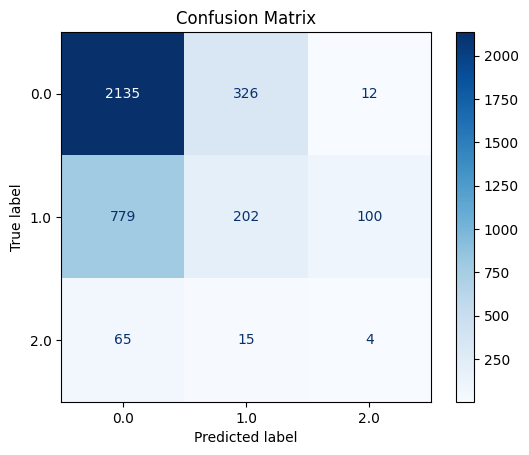

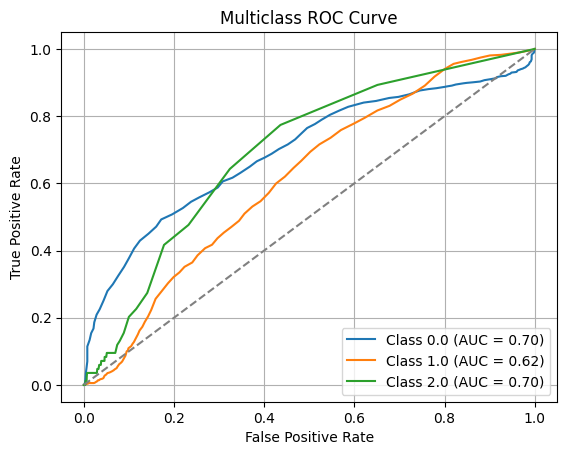

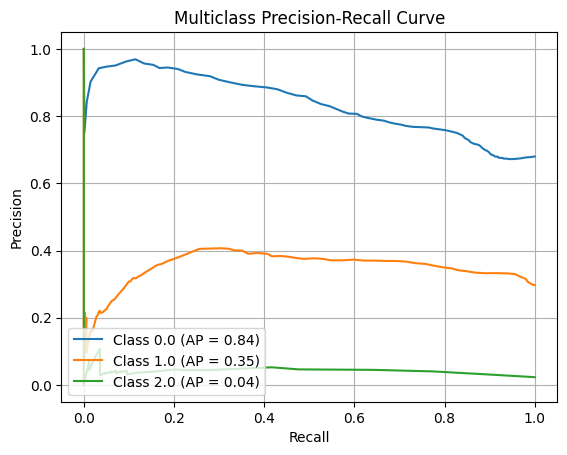

Train  Acc: 1.000,  Validation Acc: 0.601
Train  AUC: 1.000,  Validation AUC: 0.414


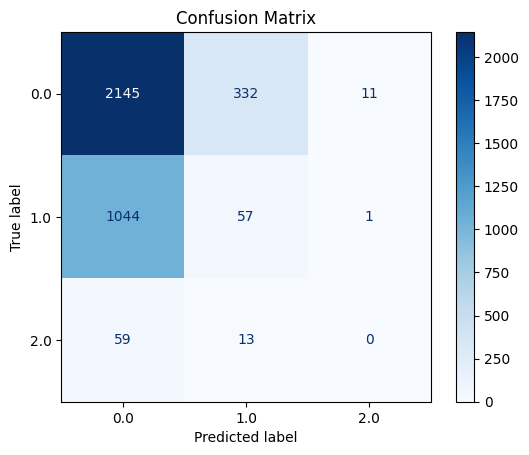

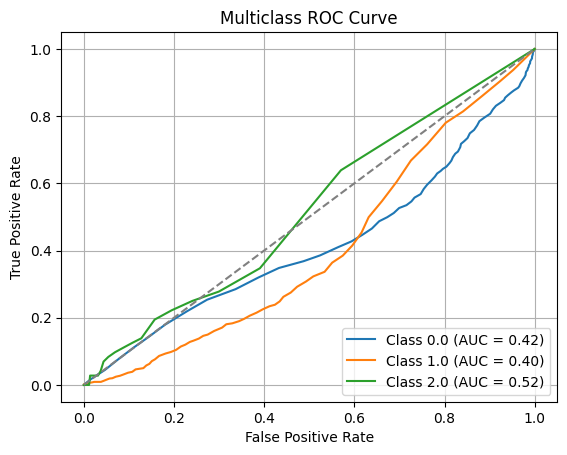

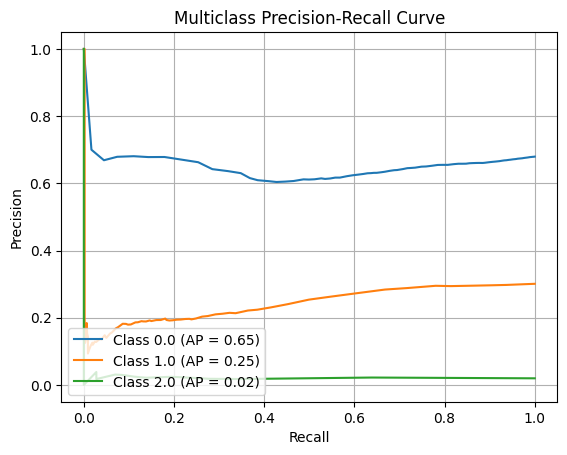

Train  Acc: 1.000,  Validation Acc: 0.574
Train  AUC: 1.000,  Validation AUC: 0.477


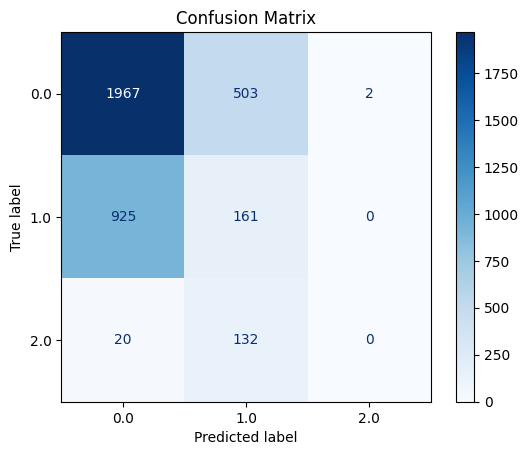

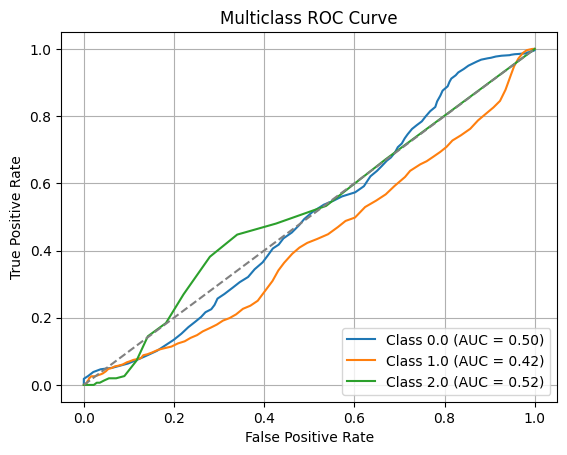

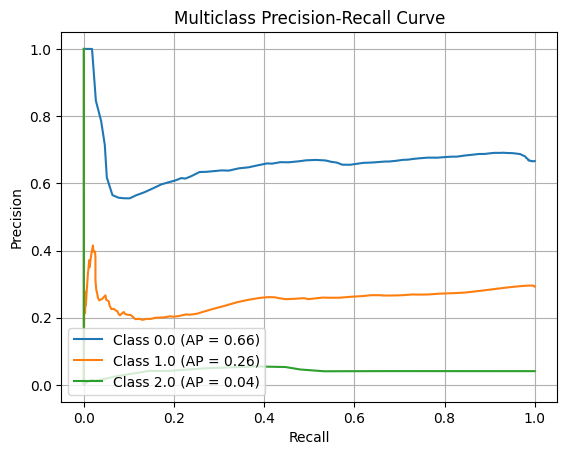

Train  Acc: 1.000,  Validation Acc: 0.628
Train  AUC: 1.000,  Validation AUC: 0.587


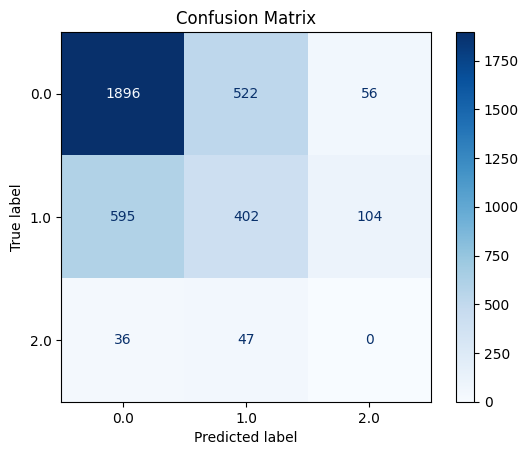

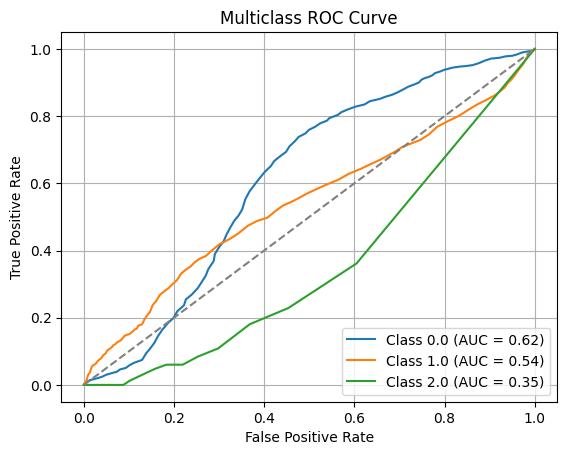

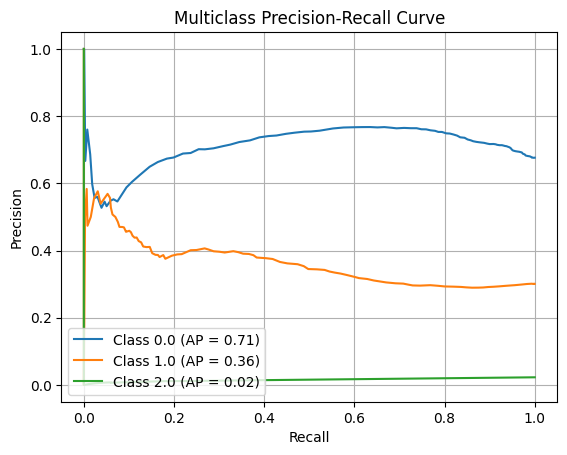

Train  Acc: 1.000,  Validation Acc: 0.616
Train  AUC: 1.000,  Validation AUC: 0.557


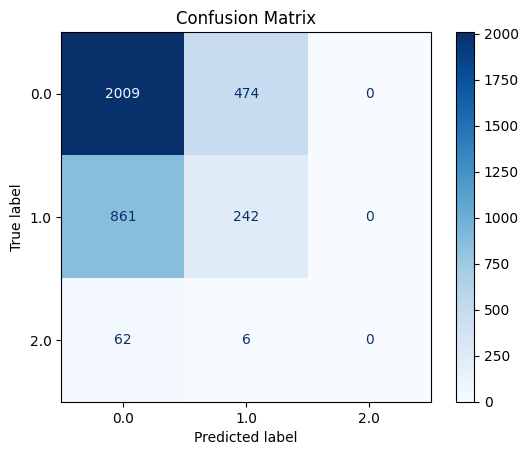

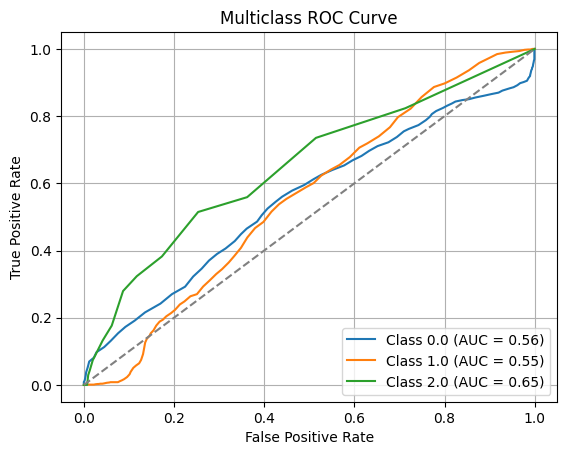

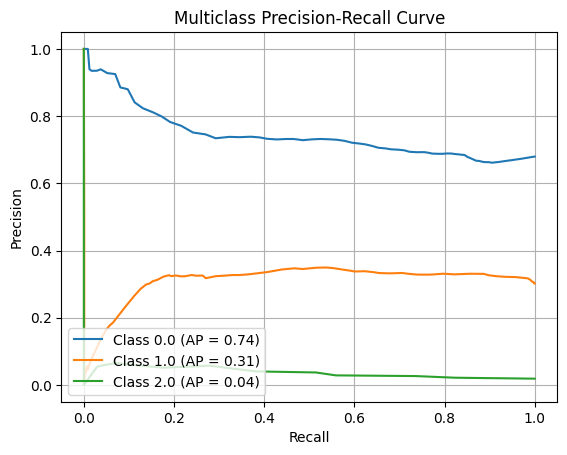

In [68]:
modelsSGK = []
for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc, train_auc, val_auc = train_evaluate_visualize(
        X_tr, y_tr,
        X_vl, y_vl
    )

    modelsSGK.append(model)

# XGBoost

In [69]:
# Step 1: Get unique user IDs
unique_users = fb_data['fitbit_user_id'].unique()

# Step 2: Split user IDs into train/test
train, test = train_test_split(
    unique_users, test_size=0.2, random_state=42
)

# Step 3: Filter original DataFrame based on user ID
train = fb_data[fb_data['fitbit_user_id'].isin(train)].reset_index(drop=True)
test = fb_data[fb_data['fitbit_user_id'].isin(test)].reset_index(drop=True)

x_train = train[measure_cols+survey_cols]
y_train = train[result_col]
x_test = test[measure_cols+survey_cols]
y_test = test[result_col]

In [70]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [71]:
# Predict class and probabilities
y_pred = xgb.predict(x_test)
y_prob = xgb.predict_proba(x_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6512427287149656
Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      2558
         1.0       0.36      0.31      0.33      1019
         2.0       0.00      0.00      0.00       205

    accuracy                           0.65      3782
   macro avg       0.37      0.38      0.37      3782
weighted avg       0.60      0.65      0.62      3782

AUC Score: 0.6385433233188719
Confusion Matrix:
 [[2143  412    3]
 [ 699  320    0]
 [  45  160    0]]


CV

In [72]:
x = fb_data[measure_cols+survey_cols+['fitbit_user_id']]
targets = fb_data[result_col]

sgkf = StratifiedGroupKFold(n_splits=5)

groups = x['fitbit_user_id']  # or however you track user grouping

In [73]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)

In [74]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="accuracy")

array([0.56789445, 0.55324959, 0.5212938 , 0.5647895 , 0.58757526])

In [75]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="f1_macro")

array([0.286771  , 0.27430664, 0.29872636, 0.35524728, 0.34555958])

In [76]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="f1_weighted")

array([0.5288092 , 0.50309795, 0.51452388, 0.57766839, 0.57903255])

In [77]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="roc_auc_ovr_weighted")

array([0.41313419, 0.49813597, 0.42836912, 0.56489398, 0.5056329 ])

In [80]:
# Define parameter space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # more = better, but slower
    scoring='f1_macro',
    n_jobs=-1,
    cv=sgkf.split(x, targets, groups=groups),
    verbose=1,
    random_state=42
)

search.fit(x, targets, groups=groups)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best ROC AUC: 0.3258298547635515


In [81]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'n_estimators': [150, 200, 250]
}

search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=sgkf.split(x, targets, groups=groups),
    verbose=1
)

search.fit(x, targets, groups=groups)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}
Best ROC AUC: nan


In [82]:
best_params = {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

In [83]:
def train_evaluate_visualize(X_train, y_train, X_val, y_val, **params):
    classes = np.unique(y_train)
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    y_prob_train = model.predict_proba(X_train)
    y_prob_val = model.predict_proba(X_val)

    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    train_auc = roc_auc_score(y_train, y_prob_train, multi_class='ovr', average='weighted')
    val_auc = roc_auc_score(y_val, y_prob_val, multi_class='ovr', average='weighted')

    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Multiclass ROC Curves
    y_val_bin = label_binarize(y_val, classes=classes)
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob_val[:, i])
        auc_score = roc_auc_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Multiclass PR Curves
    plt.figure()
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_prob_val[:, i])
        ap_score = average_precision_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(recall, precision, label=f'Class {class_label} (AP = {ap_score:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multiclass Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return model, train_acc, val_acc, train_auc, val_auc

Train  Acc: 0.800,  Validation Acc: 0.631
Train  AUC: 0.896,  Validation AUC: 0.483


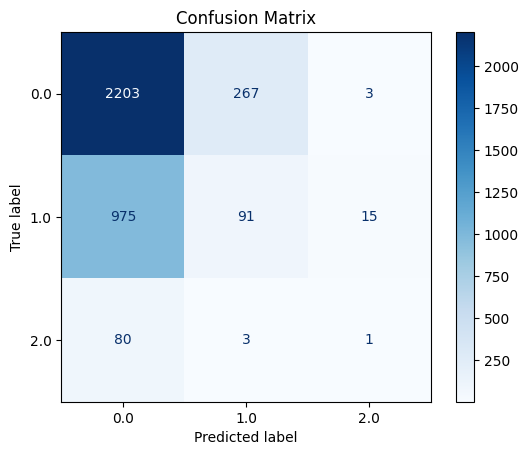

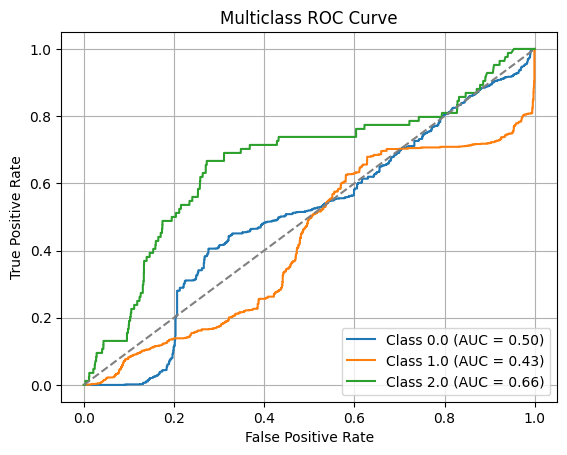

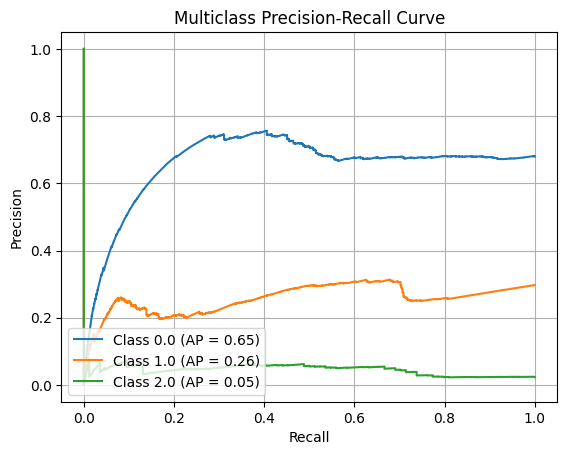

Train  Acc: 0.830,  Validation Acc: 0.539
Train  AUC: 0.897,  Validation AUC: 0.390


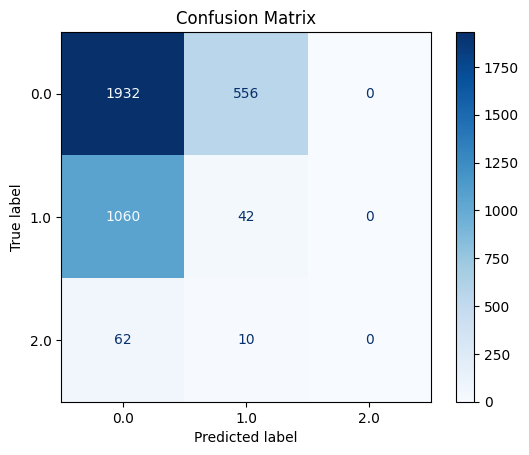

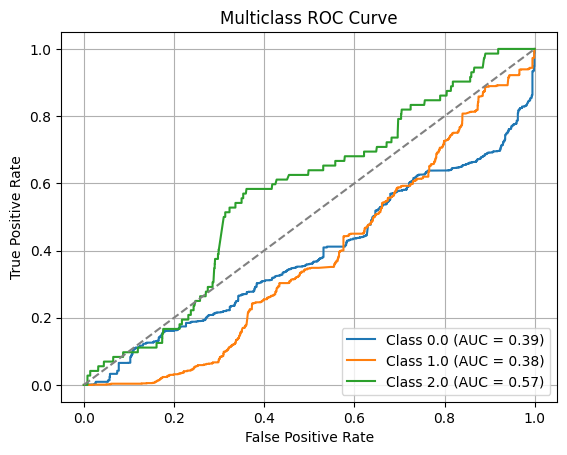

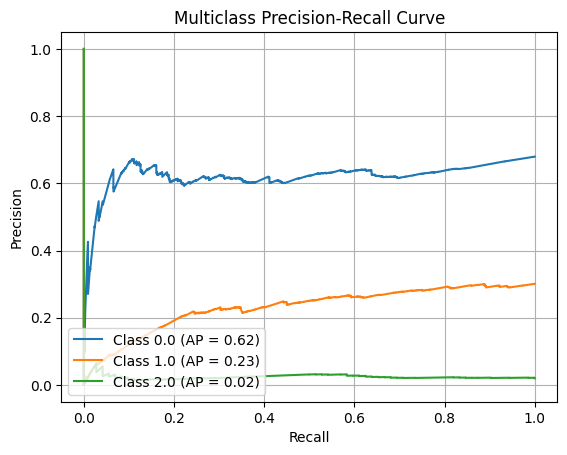

Train  Acc: 0.793,  Validation Acc: 0.677
Train  AUC: 0.877,  Validation AUC: 0.504


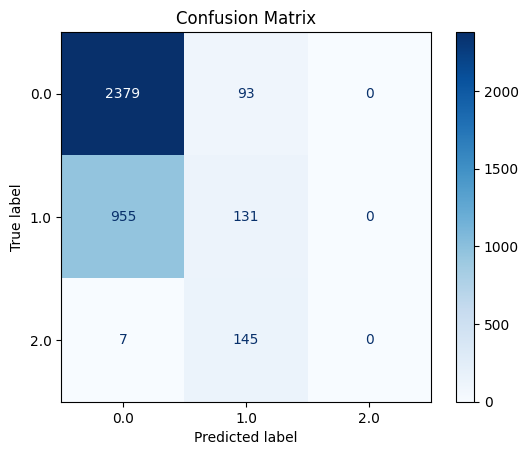

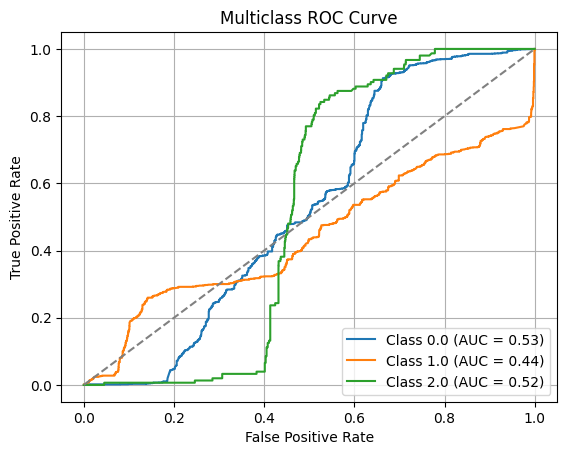

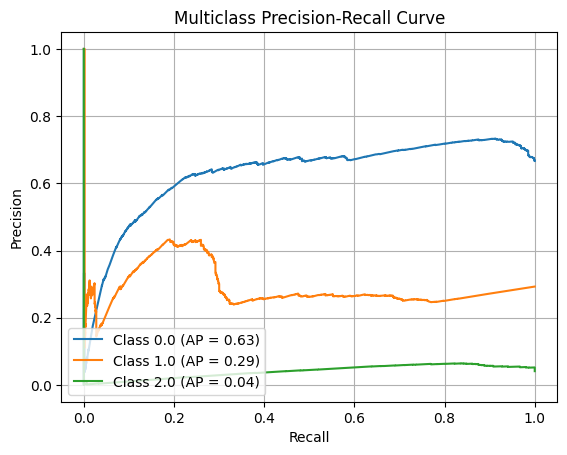

Train  Acc: 0.806,  Validation Acc: 0.615
Train  AUC: 0.893,  Validation AUC: 0.630


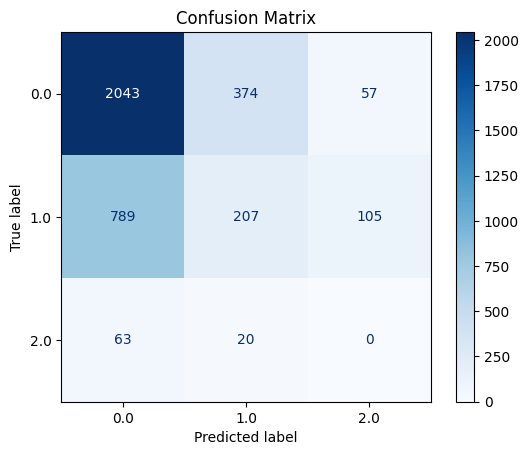

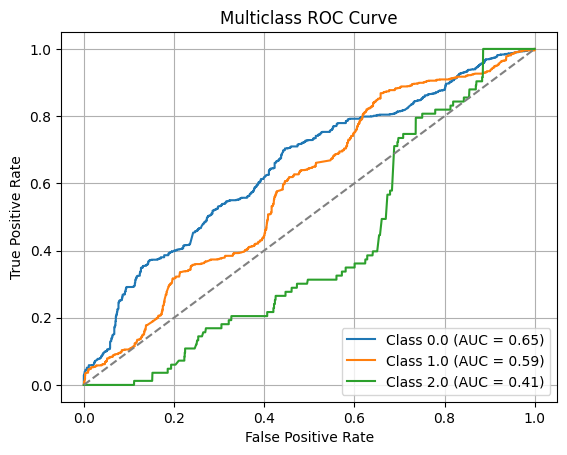

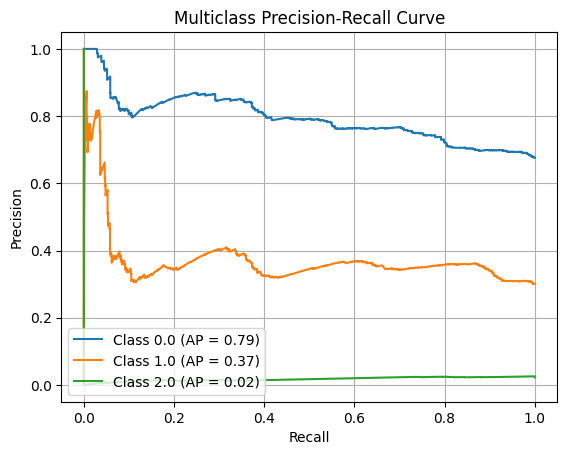

Train  Acc: 0.791,  Validation Acc: 0.640
Train  AUC: 0.856,  Validation AUC: 0.529


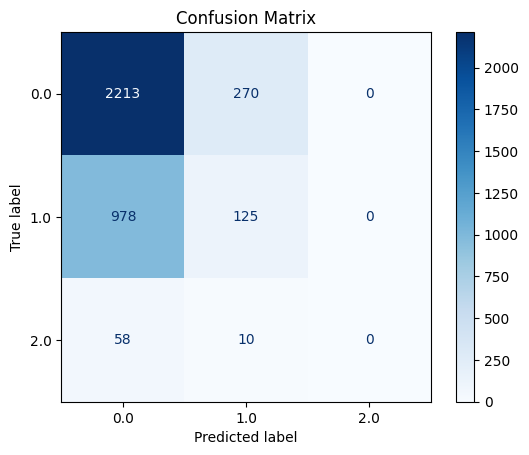

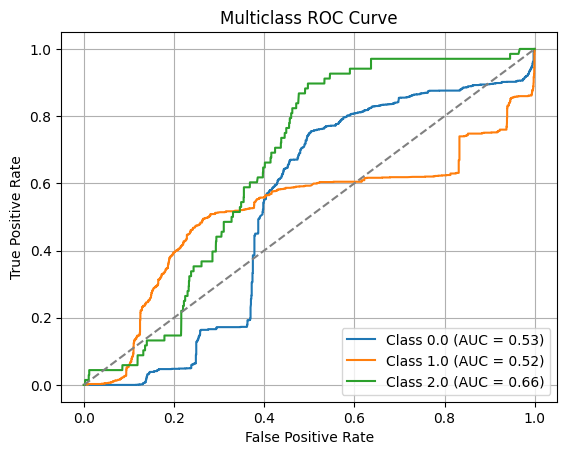

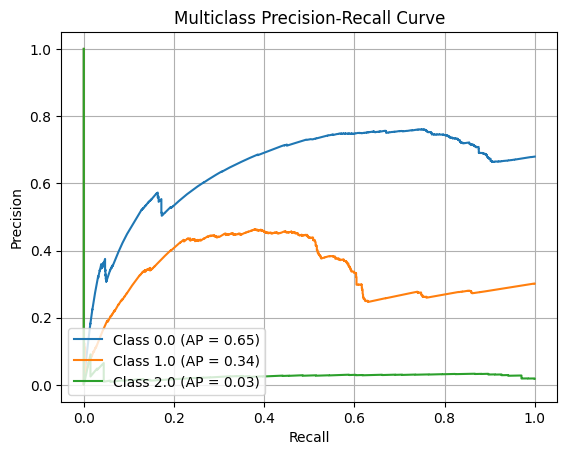

In [84]:
modelsSGK = []
for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc, train_auc, val_auc = train_evaluate_visualize(
        X_tr, y_tr,
        X_vl, y_vl,
        **best_params
    )

    modelsSGK.append(model)